# Hospital ward dynamic contact network

Notebook permettant d'analyser le graphe de contacts entre le personnel soignant, administratif et les patients d'un service hospitalier.

## Chargement et préparation des données

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


df = pd.read_csv("./data/detailed_list_of_contacts_Hospital.dat", delimiter="\t", header=None)

df.head()

,0,1,2,3,4
0,140,1157,1232,MED,ADM
1,160,1157,1191,MED,MED
2,500,1157,1159,MED,MED
3,520,1157,1159,MED,MED
4,560,1159,1191,MED,MED


### Graphe simple
Une seule arête entre les noeuds mais pondérée par la somme des durées des contacts entre les noeuds

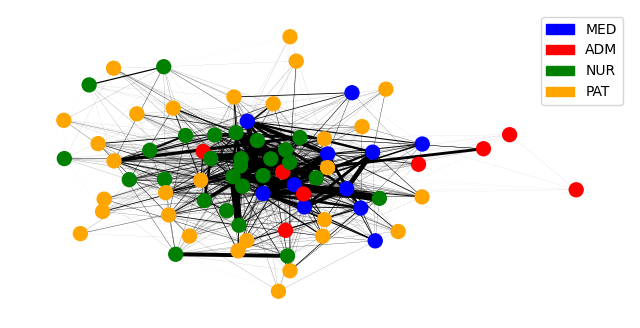

In [2]:
# Remplacement de la première colonne par 20 secondes (le temps de contact) au lieu du moment du contact
df[0] = 20

# Simple weighted Graph

G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    
    Si = group[3].iloc[0]   # catégorie du noeud i
    Sj = group[4].iloc[0]   # catégorie du noeud j

    # Ajouter les noeuds
    G.add_node(i, category=Si)
    G.add_node(j, category=Sj)

    # Somme des temps de contact
    total_t = group[0].sum()

    # Ajouter l'arête pondérée
    G.add_edge(i, j, t=total_t)


# Plot d'un premier graphe pondéré

# Couleurs des noeuds des différentes catégories
color_map = {
    "MED": "blue",
    "ADM": "red",
    "NUR": "green",
    "PAT": "orange"
}

node_colors = [color_map[G.nodes[n]["category"]] for n in G.nodes()]

plt.figure(figsize=(8, 4))

# Ajout de la légende
legend_handles = [mpatches.Patch(color=color, label=cat) 
                  for cat, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best")

# Normalisation pour affichage des arêtes pondérées
edges = G.edges()
edge_weights = [G[u][v]["t"] for u, v in edges]
max_w = max(edge_weights)
edge_widths = [10 * (w / max_w) for w in edge_weights] 


# Génération du graphe
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_color=node_colors,
    node_size=100,
    width=edge_widths,
    edge_color="black",
    with_labels=False
)
plt.savefig('./figures/hospital_weighted_graph.png')
plt.show()


## Analyse

### Première propriétés basiques

#### Distribution des degrés

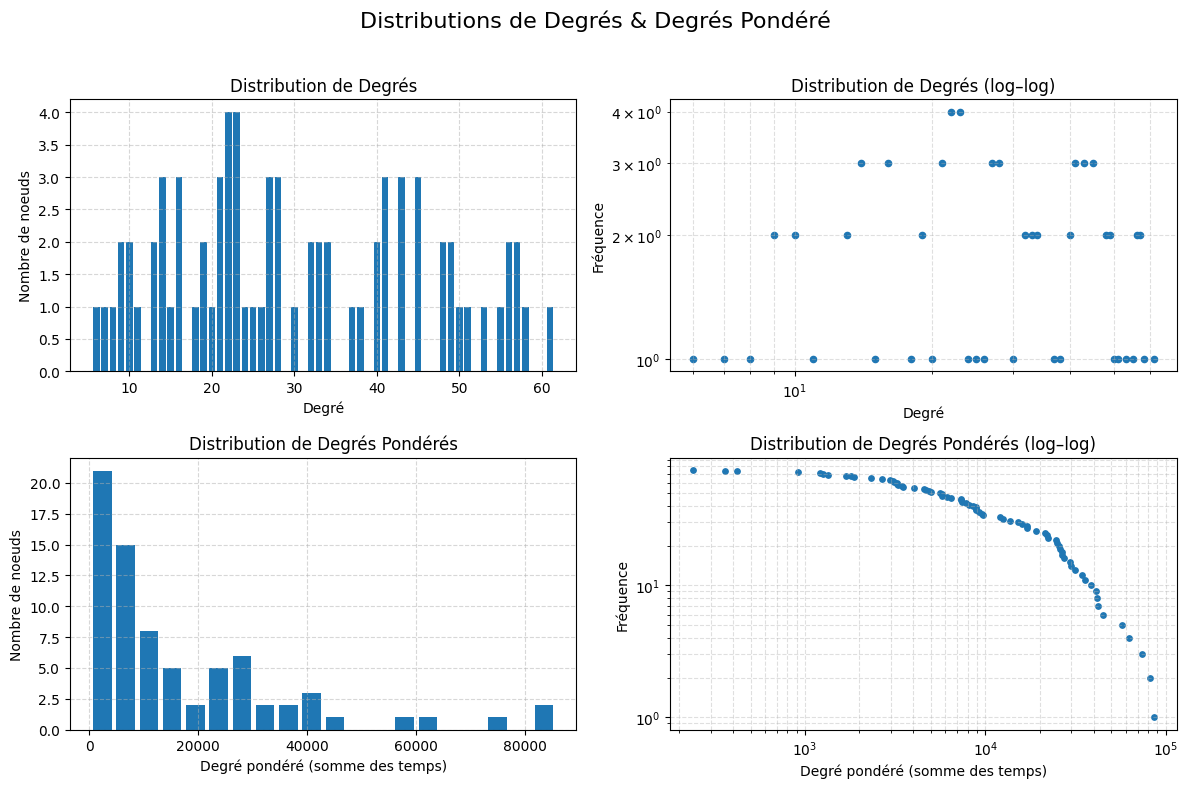

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def plot_combined_degree_distributions(G, savepath=None):
    """
    Produit une figure 2x2 avec :
      1. Histogramme du degré
      2. Log-log scatter (degré)
      3. Histogramme du degré pondéré
      4. Log-log rank plot du degré pondéré
    """

    # --------------------------
    # 1. DEGRÉS NON PONDÉRÉS
    # --------------------------

    degrees = [d for _, d in G.degree()]

    # histogramme
    bins_deg = range(min(degrees), max(degrees) + 2)

    # log-log scatter
    degree_count = {}
    for d in degrees:
        degree_count[d] = degree_count.get(d, 0) + 1

    x_deg = np.array(list(degree_count.keys()))
    y_deg = np.array(list(degree_count.values()))

    # --------------------------
    # 2. DEGRÉS PONDÉRÉS (STRENGTH)
    # --------------------------

    weighted_degrees = [d for _, d in G.degree(weight="t")]

    # histogramme weighted
    bins_wdeg = 20

    # rank plot (log-log)
    wdeg_sorted = np.sort(weighted_degrees)[::-1]
    ranks = np.arange(1, len(wdeg_sorted) + 1)

    # --------------------------
    # FIGURE COMBINÉE
    # --------------------------

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Distributions de Degrés & Degrés Pondéré", fontsize=16)

    # --- 1. Histogramme du degré ---
    axes[0, 0].hist(degrees, bins=bins_deg, align='left', rwidth=0.8)
    axes[0, 0].set_title("Distribution de Degrés")
    axes[0, 0].set_xlabel("Degré")
    axes[0, 0].set_ylabel("Nombre de noeuds")
    axes[0, 0].grid(True, linestyle='--', alpha=0.5)

    # --- 2. Log-log scatter (degree) ---
    axes[0, 1].scatter(x_deg, y_deg, s=20)
    axes[0, 1].set_xscale("log")
    axes[0, 1].set_yscale("log")
    axes[0, 1].set_title("Distribution de Degrés (log–log)")
    axes[0, 1].set_xlabel("Degré")
    axes[0, 1].set_ylabel("Fréquence")
    axes[0, 1].grid(True, which="both", linestyle="--", alpha=0.4)

    # --- 3. Histogramme du weighted degree ---
    axes[1, 0].hist(weighted_degrees, bins=bins_wdeg, rwidth=0.8)
    axes[1, 0].set_title("Distribution de Degrés Pondérés")
    axes[1, 0].set_xlabel("Degré pondéré (somme des temps)")
    axes[1, 0].set_ylabel("Nombre de noeuds")
    axes[1, 0].grid(True, linestyle='--', alpha=0.5)

    # --- 4. Log-log rank plot weighted degree ---
    axes[1, 1].scatter(wdeg_sorted, ranks, s=15)
    axes[1, 1].set_xscale("log")
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_title("Distribution de Degrés Pondérés (log–log)")
    axes[1, 1].set_xlabel("Degré pondéré (somme des temps)")
    axes[1, 1].set_ylabel("Fréquence")
    axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')

    plt.show()


# ---------------------------
# APPEL DE LA FONCTION
# ---------------------------

plot_combined_degree_distributions(G, savepath="figures/hospital_degree_combined.png")


In [4]:
# Extraction des 10 noeuds les plus important 
cat = nx.get_node_attributes(G, "category")

df_deg = pd.DataFrame({
    "node": [n for n, d in G.degree()],
    "degree": [d for n, d in G.degree()],
    "weighted_degree": [d for n, d in G.degree(weight="t")],
    "category": [cat[n] for n in G.nodes()],
})

# sur base de leur degré
print(df_deg.sort_values("degree", ascending=False).head(10))

# sur base de leur degré pondéré
print(df_deg.sort_values("weighted_degree", ascending=False).head(10))


    node  degree  weighted_degree category
0   1098      61            29600      ADM
22  1193      58            44720      NUR
6   1115      57            85720      NUR
16  1164      57            42180      NUR
34  1295      56            73900      NUR
28  1210      56            81540      NUR
4   1109      55            34220      NUR
14  1157      53            56980      MED
56  1658      51            24840      ADM
10  1144      50            40900      MED
    node  degree  weighted_degree category
6   1115      57            85720      NUR
28  1210      56            81540      NUR
34  1295      56            73900      NUR
26  1207      49            62600      NUR
14  1157      53            56980      MED
22  1193      58            44720      NUR
16  1164      57            42180      NUR
29  1221      41            41500      MED
10  1144      50            40900      MED
12  1149      48            38680      NUR


#### Coeffcient de Clustering

In [5]:
# clustering non pondéré moyen
avg_clust = nx.average_clustering(G)
print("Average clustering (unweighted) :", avg_clust)

# Local clustering coefficients (non pondéré)
clust_nodes = nx.clustering(G) 

nx.set_node_attributes(G, clust_nodes, "clustering")

# Récupérer category pour chaque noeud
cat = nx.get_node_attributes(G, "category")

# Construction dataframe
dfc = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [cat[n] for n in G.nodes()],
    "clustering": [clust_nodes[n] for n in G.nodes()],
})

# Moyennes par catégorie
by_cat = dfc.groupby("category").agg({
    "clustering": ["mean", "median", "count"],
})
print(by_cat)

Average clustering (unweighted) : 0.6402796539914468
         clustering                
               mean    median count
category                           
ADM        0.701624  0.734392     8
MED        0.655725  0.641536    11
NUR        0.548132  0.558405    27
PAT        0.703291  0.707510    29


#### Centralité (non pondérée)

In [6]:
# Degree
degree_dict = dict(G.degree())

# Betweenness
betweenness_dict = nx.betweenness_centrality(G, normalized=True)

# Closeness
closeness_dict = nx.closeness_centrality(G)

# Katz centrality (alpha < 1/lambda_max)
katz_dict = nx.katz_centrality_numpy(G, alpha=0.005, beta=1.0)

# PageRank non pondéré
pagerank_dict = nx.pagerank(G, weight=None)

# ================
# DATAFRAME COMPLET
# ================

df_cent = pd.DataFrame({
    'node': list(G.nodes()),
    'category': [G.nodes[n]['category'] for n in G.nodes()],
    'degree': [degree_dict[n] for n in G.nodes()],
    'betweenness': [betweenness_dict[n] for n in G.nodes()],
    'closeness': [closeness_dict[n] for n in G.nodes()],
    'katz': [katz_dict[n] for n in G.nodes()],
    'pagerank': [pagerank_dict[n] for n in G.nodes()],
})

# ================
# FONCTION TOP-K
# ================

def show_topk(df, measure, k=10):
    top = df.sort_values(by=measure, ascending=False).head(k)
    print(f"\n=== Top {k} – {measure} ===")
    print(top[['node', 'category', measure]].to_string(index=False))
    return top

# Appels : affichage des tables
top_degree     = show_topk(df_cent, 'degree')
top_betweenness = show_topk(df_cent, 'betweenness')
top_closeness   = show_topk(df_cent, 'closeness')
top_katz        = show_topk(df_cent, 'katz')
top_pagerank    = show_topk(df_cent, 'pagerank')



=== Top 10 – degree ===
 node category  degree
 1098      ADM      61
 1193      NUR      58
 1115      NUR      57
 1164      NUR      57
 1295      NUR      56
 1210      NUR      56
 1109      NUR      55
 1157      MED      53
 1658      ADM      51
 1144      MED      50

=== Top 10 – betweenness ===
 node category  betweenness
 1098      ADM     0.040408
 1193      NUR     0.035156
 1164      NUR     0.031266
 1115      NUR     0.028689
 1109      NUR     0.027835
 1295      NUR     0.026828
 1210      NUR     0.026450
 1658      ADM     0.022657
 1190      NUR     0.022165
 1157      MED     0.021652

=== Top 10 – closeness ===
 node category  closeness
 1098      ADM   0.850575
 1193      NUR   0.822222
 1115      NUR   0.813187
 1164      NUR   0.813187
 1295      NUR   0.804348
 1210      NUR   0.804348
 1109      NUR   0.795699
 1157      MED   0.778947
 1658      ADM   0.762887
 1144      MED   0.755102

=== Top 10 – katz ===
 node category     katz
 1098      ADM 0.132616

### Modèles de réseau

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Données du graphe réel
# -----------------------------

N = G.number_of_nodes()
M = G.number_of_edges()

# Probabilité ER correspondante
p = (2*M) / (N*(N-1))

# -----------------------------
# Modèles
# -----------------------------

# 1) ER random graph
G_er = nx.gnp_random_graph(N, p)

# 2) Configuration Model (avec préservation du degree sequence)
deg_seq = [d for _, d in G.degree()]
G_cm_multi = nx.configuration_model(deg_seq)   # multigraph
G_cm = nx.Graph(G_cm_multi)                    # conversion en graphe simple
G_cm.remove_edges_from(nx.selfloop_edges(G_cm))

# 3) Barabási–Albert
# Choix de m = M/N approx = degree moyen / 2
m_ba = max(1, int(np.mean(deg_seq) // 2))
G_ba = nx.barabasi_albert_graph(N, m_ba)

# -----------------------------
# Fonction utilitaire : mesures
# -----------------------------

def summary_stats(H, name):
    print(f"\n=== {name} ===")
    print("Nodes:", H.number_of_nodes())
    print("Edges:", H.number_of_edges())
    print("Density:", nx.density(H))
    print("Average clustering:", nx.average_clustering(H))
    try:
        print("Average shortest path length:", nx.average_shortest_path_length(H))
    except:
        print("Average shortest path length: not connected")

summary_stats(G, "Real Hospital Graph")
summary_stats(G_er, "ER model")
summary_stats(G_cm, "Configuration Model")
summary_stats(G_ba, "BA model")



=== Real Hospital Graph ===
Nodes: 75
Edges: 1139
Density: 0.4104504504504505
Average clustering: 0.6402796539914468
Average shortest path length: 1.597837837837838

=== ER model ===
Nodes: 75
Edges: 1158
Density: 0.4172972972972973
Average clustering: 0.4243034965900825
Average shortest path length: 1.5827027027027027

=== Configuration Model ===
Nodes: 75
Edges: 837
Density: 0.3016216216216216
Average clustering: 0.37545953290193634
Average shortest path length: 1.710990990990991

=== BA model ===
Nodes: 75
Edges: 900
Density: 0.32432432432432434
Average clustering: 0.44820640812175405
Average shortest path length: 1.677117117117117


In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Données du graphe réel
# -----------------------------

N = G.number_of_nodes()
M = G.number_of_edges()

# Probabilité ER correspondante
p = (2*M) / (N*(N-1))

# -----------------------------
# Modèles
# -----------------------------

# 1) ER random graph
G_er = nx.gnp_random_graph(N, p)

# 2) Configuration Model (avec préservation du degree sequence)
deg_seq = [d for _, d in G.degree()]
G_cm_multi = nx.configuration_model(deg_seq)   # multigraph
G_cm = nx.Graph(G_cm_multi)                    # conversion en graphe simple
G_cm.remove_edges_from(nx.selfloop_edges(G_cm))

# 3) Barabási–Albert
# Choix de m = M/N approx = degree moyen / 2
m_ba = max(1, int(np.mean(deg_seq) // 2))
G_ba = nx.barabasi_albert_graph(N, m_ba)

# -----------------------------
# Fonction utilitaire : mesures
# -----------------------------

def summary_stats(H, name):
    print(f"\n=== {name} ===")
    print("Nodes:", H.number_of_nodes())
    print("Edges:", H.number_of_edges())
    print("Density:", nx.density(H))
    print("Average clustering:", nx.average_clustering(H))
    try:
        print("Average shortest path length:", nx.average_shortest_path_length(H))
    except:
        print("Average shortest path length: not connected")

summary_stats(G, "Real Hospital Graph")
summary_stats(G_er, "ER model")
summary_stats(G_cm, "Configuration Model")
summary_stats(G_ba, "BA model")



=== Real Hospital Graph ===
Nodes: 75
Edges: 1139
Density: 0.4104504504504505
Average clustering: 0.6402796539914468
Average shortest path length: 1.597837837837838

=== ER model ===
Nodes: 75
Edges: 1141
Density: 0.4111711711711712
Average clustering: 0.4117811142397361
Average shortest path length: 1.5888288288288288

=== Configuration Model ===
Nodes: 75
Edges: 863
Density: 0.310990990990991
Average clustering: 0.3989879132107141
Average shortest path length: 1.7005405405405405

=== BA model ===
Nodes: 75
Edges: 900
Density: 0.32432432432432434
Average clustering: 0.42295075912056657
Average shortest path length: 1.6763963963963964


### Détection de communautés (Louvain)

Modularity: 0.0962
Number of communities: 4
Community sizes (id : size):
  0 : 23
  1 : 25
  2 : 21
  3 : 6

Composition des communautés :
category   ADM  MED  NUR  PAT  size
community                          
1            0    1   11   13    25
0            6    1    8    8    23
2            2    9    5    5    21
3            0    0    3    3     6


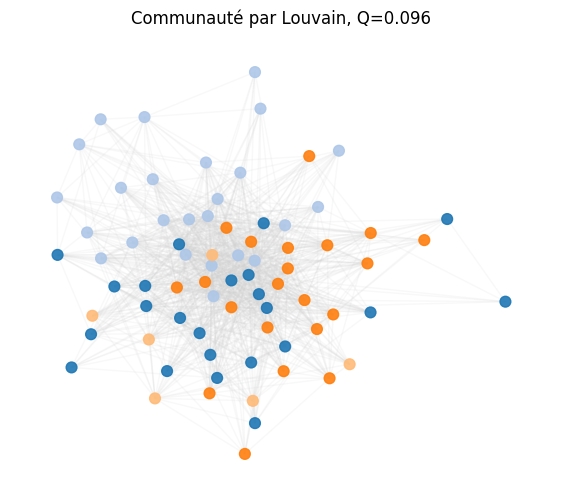

In [9]:
import community as community_louvain

# ---------------------------
# 1) Partition Louvain
# ---------------------------

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

# ---------------------------
# 2) Modularity & community sizes
# ---------------------------

modularity = community_louvain.modularity(partition, G)

from collections import Counter
comm_counts = Counter(partition.values())
n_comms = len(comm_counts)

print(f"Modularity: {modularity:.4f}")
print(f"Number of communities: {n_comms}")
print("Community sizes (id : size):")
for cid, size in comm_counts.items():
    print(f"  {cid} : {size}")

# ---------------------------
# 3) Composition par catégorie
# ---------------------------

df_nodes = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]['category'] for n in G.nodes()],
    "community": [partition[n] for n in G.nodes()]
})

comp_table = pd.crosstab(df_nodes["community"], df_nodes["category"])
comp_table["size"] = comp_table.sum(axis=1)
comp_table = comp_table.sort_values("size", ascending=False)

print("\nComposition des communautés :")
print(comp_table)

# ---------------------------
# 4) Affichage du graphe coloré par communauté
# ---------------------------

pos = nx.spring_layout(G, seed=42)

# palette
import matplotlib.cm as cm
palette = [cm.tab20(i) for i in range(20)]
colors = [palette[partition[n] % 20] for n in G.nodes()]

plt.figure(figsize=(7, 6))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=60, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.15)
plt.axis("off")
plt.title(f"Communauté par Louvain, Q={modularity:.3f}")
plt.savefig('./figures/hospital_communities_louvain.png')
plt.show()


#### Dynamique

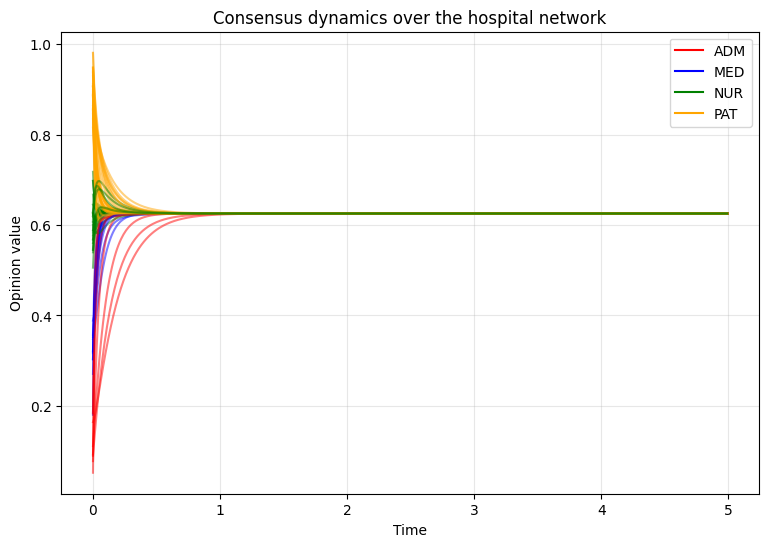

Final consensus value ≈ 0.625455438285156


In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# 1) Laplacian dynamics  dx/dt = -Lx
# ---------------------------

# Laplacian matrix
L = nx.laplacian_matrix(G).astype(float).todense()

# initial conditions based on categories
# (gives a small offset per group to visualize group evolution)
cat_map = {"ADM": 0.1, "MED": 0.3, "NUR": 0.6, "PAT": 0.9}
x0 = np.array([cat_map[G.nodes[n]["category"]] + 0.05*np.random.randn()
               for n in G.nodes()])

# simulation parameters
dt = 0.01
T = 5
times = np.arange(0, T, dt)

# store trajectories
trajectories = []

x = x0.copy()
for t in times:
    trajectories.append(x.copy())
    x = x - dt * (L @ x)

trajectories = np.array(trajectories)  # shape (time, nodes)

# ---------------------------
# 2) Plot with colors by category
# ---------------------------

colors = {
    "ADM": "red",
    "MED": "blue",
    "NUR": "green",
    "PAT": "orange"
}

plt.figure(figsize=(9,6))

for i, n in enumerate(G.nodes()):
    plt.plot(times, trajectories[:, i],
             color=colors[G.nodes[n]["category"]],
             alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Opinion value")
plt.title("Consensus dynamics over the hospital network")
plt.grid(alpha=0.3)

# custom legend
for cat, col in colors.items():
    plt.plot([], [], color=col, label=cat)
plt.legend()

plt.show()

# consensus value
print("Final consensus value ≈", float(trajectories[-1].mean()))


### Random Walk

In [11]:
# --- Transition matrix T (unweighted) ---
A = nx.to_numpy_array(G)
deg = A.sum(axis=1)
deg[deg == 0] = 1
T = A / deg[:, None]   # row-stochastic

# --- Power method ---
p = np.ones(G.number_of_nodes()) / G.number_of_nodes()
for _ in range(200):
    p = p @ T

# --- Build dataframe ---
df_rw = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "stationary": p
})

df_rw = df_rw.sort_values("stationary", ascending=False)

print(df_rw.head(10))

    node category  stationary
0   1098      ADM    0.026778
22  1193      NUR    0.025461
6   1115      NUR    0.025022
16  1164      NUR    0.025022
34  1295      NUR    0.024583
28  1210      NUR    0.024583
4   1109      NUR    0.024144
14  1157      MED    0.023266
56  1658      ADM    0.022388
10  1144      MED    0.021949


### Mean First passage

Sources sélectionnées : {'ADM': np.int64(1098), 'MED': np.int64(1130), 'NUR': np.int64(1100), 'PAT': np.int64(1320)}
Simulation MFPT en cours...

MFPT moyen par catégorie source → catégorie cible :

target_cat         ADM        MED        NUR         PAT
src_cat                                                 
ADM         153.960282  74.895909  71.634815  135.738621
MED         149.259645  71.804091  71.083148  134.717414
NUR         155.195556  71.981818  69.688889  136.025152
PAT         145.855622  74.248182  70.969444  137.853966


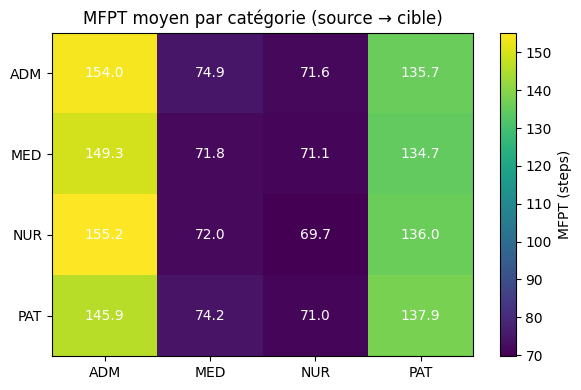

In [12]:
import random

random.seed(42)
np.random.seed(42)

# ------------------------------------------------------
# MFPT simulation sur graphe simple non pondéré
# ------------------------------------------------------
def simulate_MFPT(G, source, target, n_sim=200, max_steps=2000):
    """Simule n_sim RW jusqu'à atteindre target, renvoie MFPT moyen."""
    steps = []
    neighbors_dict = {n: list(G.neighbors(n)) for n in G.nodes()}
    
    for _ in range(n_sim):
        current = source
        for t in range(1, max_steps + 1):
            neigh = neighbors_dict[current]
            if not neigh:
                break
            current = random.choice(neigh)
            if current == target:
                steps.append(t)
                break

    return float(np.mean(steps)) if len(steps) > 0 else np.nan


# ------------------------------------------------------
# Sélection d’un nœud représentatif par catégorie
# ------------------------------------------------------
sample_sources = {
    "ADM": next(n for n in G.nodes() if G.nodes[n]["category"] == "ADM"),
    "MED": next(n for n in G.nodes() if G.nodes[n]["category"] == "MED"),
    "NUR": next(n for n in G.nodes() if G.nodes[n]["category"] == "NUR"),
    "PAT": next(n for n in G.nodes() if G.nodes[n]["category"] == "PAT")
}

print("Sources sélectionnées :", sample_sources)

targets = list(G.nodes())
n_sim = 200

rows = []

print("Simulation MFPT en cours...")

for src_label, src in sample_sources.items():
    for t in targets:
        mfpt = simulate_MFPT(G, src, t, n_sim=n_sim)
        rows.append((src_label, src, t, G.nodes[t]["category"], mfpt))

mfpt_df = pd.DataFrame(rows, columns=["src_cat", "src_id", "target", "target_cat", "MFPT"])

# ------------------------------------------------------
# Agrégation par category → category
# ------------------------------------------------------
pivot_mean = mfpt_df.pivot_table(
    index="src_cat", columns="target_cat", values="MFPT", aggfunc="mean"
)

print("\nMFPT moyen par catégorie source → catégorie cible :\n")
print(pivot_mean)


# ------------------------------------------------------
# Heatmap 
# ------------------------------------------------------
cats = ["ADM", "MED", "NUR", "PAT"]
heatmap_data = pivot_mean.loc[cats, cats].values

plt.figure(figsize=(6,4))
plt.imshow(heatmap_data, cmap="viridis", aspect="auto")
plt.colorbar(label="MFPT (steps)")

plt.xticks(range(len(cats)), cats)
plt.yticks(range(len(cats)), cats)
plt.title("MFPT moyen par catégorie (source → cible)")

# Ajout des valeurs sur la heatmap
for i in range(len(cats)):
    for j in range(len(cats)):
        val = heatmap_data[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.1f}", ha="center", va="center", color="white")

plt.tight_layout()
plt.savefig("./figures/hospital_mfp_heatmap.png", dpi=300)
plt.show()

### Markov stability

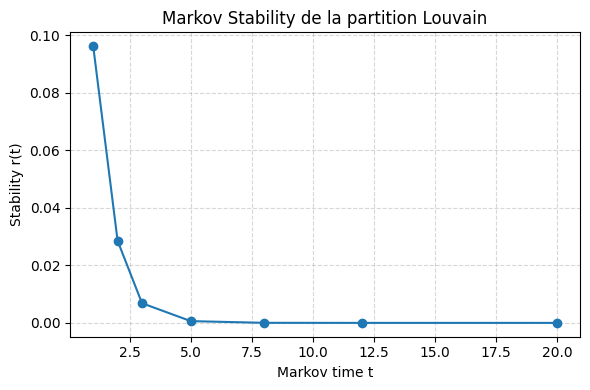

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# -----------------------------------------------------
# 1) Matrice de transition T = D^{-1} A
# -----------------------------------------------------
A = nx.to_numpy_array(G)
deg = A.sum(axis=1)
T = (A.T / deg).T   # row-normalized matrix

# Stationary distribution (degree-proportional)
pi = deg / deg.sum()
Pi = np.diag(pi)

# -----------------------------------------------------
# 2) Partition Louvain déjà calculée
# clusters[node] = community_id
# -----------------------------------------------------
comms = partition
K = max(comms.values()) + 1

# Matrix H (N × K) d'appartenance
N = len(G.nodes())
node_index = {n:i for i,n in enumerate(G.nodes())}
H = np.zeros((N, K))
for n, c in comms.items():
    H[node_index[n], c] = 1

# -----------------------------------------------------
# 3) Markov stability for different times t
# -----------------------------------------------------
def markov_stability(T, t, Pi, pi, H):
    # Propagator: discrete time walk, P(t) = T^t
    P_t = np.linalg.matrix_power(T, t)
    M = Pi @ P_t - np.outer(pi, pi)
    return np.trace(H.T @ M @ H)

times = [1, 2, 3, 5, 8, 12, 20]
stability_values = []

for t in times:
    r_t = markov_stability(T, t, Pi, pi, H)
    stability_values.append(r_t)

# -----------------------------------------------------
# 4) Plot
# -----------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(times, stability_values, marker='o')
plt.xlabel("Markov time t")
plt.ylabel("Stability r(t)")
plt.title("Markov Stability de la partition Louvain")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("./figures/hospital_markov_stability.png", dpi=300)
plt.show()


### Infomap

In [14]:
import igraph as ig

# ---------------------------------------------------------
# 1. Convertir graphe NetworkX -> igraph
# ---------------------------------------------------------
mapping = {n: i for i, n in enumerate(G.nodes())}
edges = [(mapping[u], mapping[v]) for u, v in G.edges()]

g = ig.Graph()
g.add_vertices(len(mapping))
g.add_edges(edges)

categories = [G.nodes[n]["category"] for n in G.nodes()]
g.vs["category"] = categories

# ---------------------------------------------------------
# 2. Infomap via igraph
# ---------------------------------------------------------
infomap_result = g.community_infomap()

# Vector des communautés (0,1,2,…)
communities = infomap_result.membership

df_infomap = pd.DataFrame({
    "node": list(G.nodes()),
    "community": communities,
    "category": categories
})

print(df_infomap["community"].value_counts().sort_index())
print("\nComposition par catégorie :")
print(pd.crosstab(df_infomap["community"], df_infomap["category"]))


community
0    75
Name: count, dtype: int64

Composition par catégorie :
category   ADM  MED  NUR  PAT
community                    
0            8   11   27   29


### Walktrap

In [15]:

# ---------------------------------------------------------
# 1. Conversion NetworkX -> igraph
# ---------------------------------------------------------
mapping = {n: i for i, n in enumerate(G.nodes())}
edges = [(mapping[u], mapping[v]) for u, v in G.edges()]

g = ig.Graph()
g.add_vertices(len(mapping))
g.add_edges(edges)

categories = [G.nodes[n]["category"] for n in G.nodes()]
g.vs["category"] = categories

# ---------------------------------------------------------
# 2. Walktrap (steps = 4)
# ---------------------------------------------------------
walktrap = g.community_walktrap(steps=4)
walktrap_result = walktrap.as_clustering()

memberships = walktrap_result.membership

df_walktrap = pd.DataFrame({
    "node": list(G.nodes()),
    "community": memberships,
    "category": categories
})

print("Taille des communautés Walktrap :")
print(df_walktrap["community"].value_counts().sort_index())

print("\nComposition par catégorie :")
print(pd.crosstab(df_walktrap["community"], df_walktrap["category"]))


Taille des communautés Walktrap :
community
0    67
1     6
2     2
Name: count, dtype: int64

Composition par catégorie :
category   ADM  MED  NUR  PAT
community                    
0            6   11   24   26
1            0    0    3    3
2            2    0    0    0


### Core-periphery

In [16]:
# ------------------------------------------------------
# Core number de chaque nœud
# ------------------------------------------------------
core_num = nx.core_number(G)

df_core = pd.DataFrame({
    "node": list(G.nodes()),
    "core": [core_num[n] for n in G.nodes()],
    "category": [G.nodes[n]["category"] for n in G.nodes()]
})

print(df_core.sort_values("core", ascending=False).head(15))

# ------------------------------------------------------
# Distribution des core-numbers
# ------------------------------------------------------
print("\nDistribution du core number :")
print(df_core["core"].value_counts().sort_index())

# ------------------------------------------------------
# Composition par catégorie
# ------------------------------------------------------
print("\nComposition par catégorie selon core-number :")
print(pd.crosstab(df_core["core"], df_core["category"]))


    node  core category
0   1098    22      ADM
1   1100    22      NUR
2   1105    22      NUR
3   1108    22      NUR
4   1109    22      NUR
5   1114    22      NUR
6   1115    22      NUR
8   1130    22      MED
9   1142    22      NUR
10  1144    22      MED
11  1148    22      MED
34  1295    22      NUR
12  1149    22      NUR
14  1157    22      MED
15  1159    22      MED

Distribution du core number :
core
6      1
7      2
9      2
10     2
11     1
13     4
14     2
15     1
16     2
17     4
18     2
19     6
20     4
21     3
22    39
Name: count, dtype: int64

Composition par catégorie selon core-number :
category  ADM  MED  NUR  PAT
core                        
6           1    0    0    0
7           1    0    0    1
9           0    0    0    2
10          1    0    0    1
11          0    0    0    1
13          0    0    2    2
14          0    1    0    1
15          0    0    0    1
16          0    0    1    1
17          0    0    2    2
18          0    0    0 

### Processus epidémiques

In [17]:
def simulate_SI(G, initial_infected, beta=0.05, T=30):
    """
    Simule un modèle SI sur le graphe G
    - initial_infected : liste de nœuds infectés au départ
    - beta : probabilité de transmission par lien et par pas de temps
    - T : nombre de pas de temps
    """
    infected = set(initial_infected)
    history = [len(infected)]

    for t in range(T):
        new_infected = set(infected)
        for u in infected:
            for v in G.neighbors(u):
                if v not in infected:
                    if random.random() < beta:
                        new_infected.add(v)
        infected = new_infected
        history.append(len(infected))

    return history

In [18]:
# Nœud très central (plus haut degré)
central_node = max(G.degree, key=lambda x: x[1])[0]

# Nœud périphérique (plus faible degré)
peripheral_node = min(G.degree, key=lambda x: x[1])[0]

print("Central node:", central_node, G.nodes[central_node]["category"])
print("Peripheral node:", peripheral_node, G.nodes[peripheral_node]["category"])

Central node: 1098 ADM
Peripheral node: 1525 ADM


In [19]:
T = 30
beta = 0.05

history_central = simulate_SI(G, [central_node], beta=beta, T=T)
history_peripheral = simulate_SI(G, [peripheral_node], beta=beta, T=T)

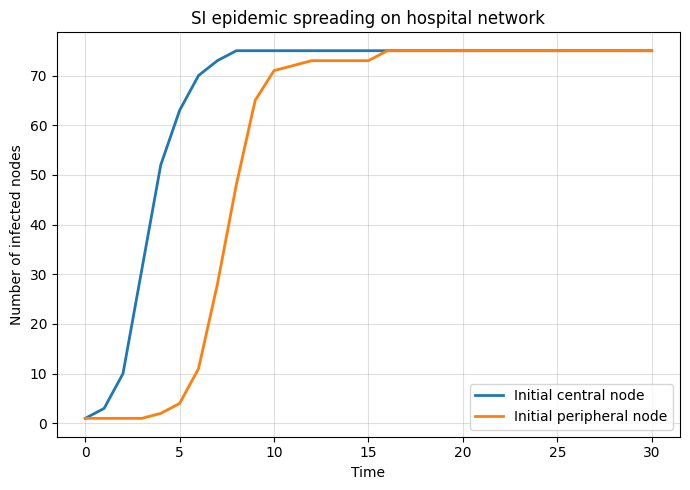

In [21]:

plt.figure(figsize=(7,5))
plt.plot(history_central, label="Initial central node", linewidth=2)
plt.plot(history_peripheral, label="Initial peripheral node", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Number of infected nodes")
plt.title("SI epidemic spreading on hospital network")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("./figures/hospital_si.png", dpi=300)
plt.show()